# Introduction

Objectif : construire une baseline simple, propre et robuste pour Home Credit.

Méthode :
- Analyse des problèmes détectés dans les variables (tableau des problèmes)
- Définition des règles de preprocessing baseline
- Préparation du pipeline baseline (imputation, flags, nettoyage léger)
- Entraînement d’un premier modèle simple

# Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append("../../src")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)


In [2]:
from data.load_data import CSVLoader

# Chargement des tables brutes

In [3]:
from data.load_data import CSVLoader

loader = CSVLoader(path="../../data/raw/")
dfs = loader.load()

df_list = loader.to_list()



Loaded: application_test               shape = (48744, 121)
Loaded: application_train              shape = (307511, 122)
Loaded: bureau                         shape = (1716428, 17)
Loaded: bureau_balance                 shape = (27299925, 3)
Loaded: credit_card_balance            shape = (3840312, 23)
Loaded: HomeCredit_columns_description shape = (219, 5)
Loaded: installments_payments          shape = (13605401, 8)
Loaded: POS_CASH_balance               shape = (10001358, 8)
Loaded: previous_application           shape = (1670214, 37)
Loaded: sample_submission              shape = (48744, 2)


## Application train
**application_train** est la table *principale* du projet Home Credit.
Elle contient une ligne par demande de crédit, avec toutes les informations nécessaires pour évaluer le risque client.
On y trouve des données personnelles, financières, professionnelles, comportementales et régionales.
Elle inclut aussi les caractéristiques du crédit demandé (montant, annuités, type de contrat).

## Application train
Même structure que application_train mais sans la TARGET.
Regroupe les demandes pour lesquelles il faut prédire le risque.
Utilisée pour générer les prédictions finales


## bureau
Historique des crédits du client dans d’autres institutions financières.
Chaque ligne représente un crédit externe.
Contient statut, montants, durées et retards éventuels.


## bureau_balance
Historique mensuel du statut des crédits présents dans bureau.
Chaque ligne correspond à un mois d’un crédit externe.
Permet d’analyser la régularité des paiements.


## credit_card_balance
Historique mensuel des cartes de crédit détenues via Home Credit.
Contient soldes, limites, paiements et montants minimums.
Indique la discipline financière du client


## installments_payments
Historique de tous les paiements d’échéances effectués par le client.
Permet de voir s’il paye en avance, à l’heure ou en retard.
Très prédictif pour le risque.

## POS_CASH_balance
Historique mensuel des crédits POS et cash loans.
Contient statut mensuel, montants restants et retards.
Utile pour analyser la stabilité sur des crédits courts.


## previous_application
Toutes les anciennes demandes de crédit du client chez Home Credit.
Inclut montants, durées, statuts et conditions.
Permet de comprendre l’historique interne du client.


## HomeCredit_columns_description
Dictionnaire des colonnes du projet.
Contient nom, table, type et description textuelle.


## sample_submission
Fichier modèle pour la soumission Kaggle.
Contient les IDs de application_test et une colonne TARGET vide.


In [4]:

from utils.eda import QuickEDA

# Analyse du dataset principal


**application_train** est la table *principale* du projet Home Credit.
Elle contient une ligne par demande de crédit, avec toutes les informations nécessaires pour évaluer le risque client.
On y trouve des données personnelles, financières, professionnelles, comportementales et régionales.
Elle inclut aussi les caractéristiques du crédit demandé (montant, annuités, type de contrat).



In [5]:
eda = QuickEDA(dfs['application_train'], name="application_train",)
num, cat, prob = eda.run(export=True)


## EDA : **application_train**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\application_train_eda.xlsx


## Valeurs numériques

In [6]:
num

,colonne,type_exact,nb_valeurs_uniques,min,max,moyenne,mediane,mode,ecart_type,q1,q3,iqr,skew,kurtosis,quasi_constante,asymetrique,kurtotique,tx_remplissage (%),nb_na,NA_massif
50,COMMONAREA_MODE,float64,3128,0.000000e+00,1.000000e+00,0.042553,0.019000,0.000000,0.074445,0.007200,0.049000,0.041800,5.620589,48.860992,False,True,True,30.127703,214865,True
36,COMMONAREA_AVG,float64,3181,0.000000e+00,1.000000e+00,0.044621,0.021100,0.000000,0.076036,0.007800,0.051500,0.043700,5.457305,45.988017,False,True,True,30.127703,214865,True
64,COMMONAREA_MEDI,float64,3202,0.000000e+00,1.000000e+00,0.044595,0.020800,0.000000,0.076144,0.007900,0.051300,0.043400,5.419238,45.263586,False,True,True,30.127703,214865,True
44,NONLIVINGAPARTMENTS_AVG,float64,386,0.000000e+00,1.000000e+00,0.008809,0.000000,0.000000,0.047732,0.000000,0.003900,0.003900,15.541185,284.730336,False,True,True,30.567037,213514,True
58,NONLIVINGAPARTMENTS_MODE,float64,167,0.000000e+00,1.000000e+00,0.008076,0.000000,0.000000,0.046276,0.000000,0.003900,0.003900,16.251819,309.726947,False,True,True,30.567037,213514,True
72,NONLIVINGAPARTMENTS_MEDI,float64,214,0.000000e+00,1.000000e+00,0.008651,0.000000,0.000000,0.047415,0.000000,0.003900,0.003900,15.671995,289.492455,False,True,True,30.567037,213514,True
56,LIVINGAPARTMENTS_MODE,float64,736,0.000000e+00,1.000000e+00,0.105645,0.077100,0.055100,0.097880,0.054200,0.131300,0.077100,2.902672,14.224994,False,True,True,31.645047,210199,True
42,LIVINGAPARTMENTS_AVG,float64,1868,0.000000e+00,1.000000e+00,0.100775,0.075600,0.050400,0.092576,0.050400,0.121000,0.070600,3.042198,16.490630,False,True,True,31.645047,210199,True
70,LIVINGAPARTMENTS_MEDI,float64,1097,0.000000e+00,1.000000e+00,0.101954,0.076100,0.051300,0.093642,0.051300,0.123100,0.071800,2.988291,15.697053,False,True,True,31.645047,210199,True
68,FLOORSMIN_MEDI,float64,47,0.000000e+00,1.000000e+00,0.231625,0.208300,0.208300,0.161934,0.083300,0.375000,0.291700,0.960226,1.346574,False,False,False,32.151370,208642,True


## Valeurs catégorielles

In [7]:
cat

,colonne,nb_valeurs_uniques,valeur_plus_frequente,pourcentage valeur plus fréquente (%),entropie,quasi_constante,dominance,cardinalite_elevee,asymetrique,entropie_faible,tx_remplissage (%),nb_na,NA_massif
12,FONDKAPREMONT_MODE,4,reg oper account,24.01,0.889613,False,False,False,False,True,31.613828,210295,True
14,WALLSMATERIAL_MODE,7,Panel,21.48,1.339720,False,False,False,False,False,49.159217,156341,True
13,HOUSETYPE_MODE,3,block of flats,48.94,0.573439,False,False,False,False,True,49.823909,154297,True
15,EMERGENCYSTATE_MODE,2,No,51.84,0.544686,True,False,False,False,True,52.601696,145755,True
9,OCCUPATION_TYPE,18,Laborers,17.95,2.638930,False,False,False,False,False,68.654455,96391,False
4,NAME_TYPE_SUITE,7,Unaccompanied,80.82,0.952978,False,False,False,True,True,99.579852,1292,False
0,NAME_CONTRACT_TYPE,2,Cash loans,90.48,0.453634,True,True,False,True,True,100.000000,0,False
1,CODE_GENDER,3,F,65.83,0.926604,False,False,False,False,True,100.000000,0,False
2,FLAG_OWN_CAR,2,N,65.99,0.924922,True,False,False,False,True,100.000000,0,False
3,FLAG_OWN_REALTY,2,Y,69.37,0.888888,True,False,False,False,True,100.000000,0,False


In [8]:
prob


,colonne,NA_massif,asymetrique,cardinalite_elevee,dominance,entropie_faible,kurtotique,quasi_constante
0,COMMONAREA_MODE,OUI,OUI,,,,OUI,
1,COMMONAREA_AVG,OUI,OUI,,,,OUI,
2,COMMONAREA_MEDI,OUI,OUI,,,,OUI,
3,NONLIVINGAPARTMENTS_AVG,OUI,OUI,,,,OUI,
4,NONLIVINGAPARTMENTS_MODE,OUI,OUI,,,,OUI,
5,NONLIVINGAPARTMENTS_MEDI,OUI,OUI,,,,OUI,
6,LIVINGAPARTMENTS_MODE,OUI,OUI,,,,OUI,
7,LIVINGAPARTMENTS_AVG,OUI,OUI,,,,OUI,
8,LIVINGAPARTMENTS_MEDI,OUI,OUI,,,,OUI,
9,FLOORSMIN_MEDI,OUI,,,,,,


## Structure et du typage des colonnes 

La table `application_train` contient une ligne par client ayant obtenu un crédit.  
Le typage général est cohérent, mais plusieurs ajustements sont nécessaires pour optimiser la lisibilité, la mémoire et la préparation des modèles.

---

### Typage global

- Les **variables numériques** (`int64`, `float64`) sont correctement typées : montants, durées, scores externes, jours relatifs.
- Les **variables catégorielles** sont en `object` : type de contrat, genre, niveau d’éducation, type de logement.
- Les **variables binaires** (0/1 ou Y/N) sont en `int64` ou `object` → doivent être converties en `bool`.

les colonnes concernées  
- les types d’outliers  
- les valeurs aberrantes connues  
- la stratégie baseline (on garde tout)  
 
### Conversion des colonnes binaires en booléens
Les colonnes 0/1 ou Y/N doivent devenir `bool` pour plus de clarté et une meilleure préparation des modèles.

Exemples :
- `FLAG_OWN_CAR` → Y/N → bool
- `FLAG_OWN_REALTY` → Y/N → bool
- `FLAG_MOBIL`, `FLAG_EMP_PHONE`, `FLAG_WORK_PHONE`, `FLAG_CONT_MOBILE`, `FLAG_PHONE`, `FLAG_EMAIL`
- `REG_REGION_NOT_LIVE_REGION`, `REG_REGION_NOT_WORK_REGION`, `LIVE_REGION_NOT_WORK_REGION`
- `REG_CITY_NOT_LIVE_CITY`, `REG_CITY_NOT_WORK_CITY`, `LIVE_CITY_NOT_WORK_CITY`
- Tous les `FLAG_DOCUMENT_2` à `FLAG_DOCUMENT_21`

---


### Colonnes à forte cardinalité (à regrouper)
Certaines colonnes ont trop de modalités et doivent être regroupées ou encodées différemment :
- `ORGANIZATION_TYPE` (58 catégories)
- `OCCUPATION_TYPE` (18 catégories)

### Conclusion
La structure des colonnes est globalement cohérente, mais plusieurs ajustements sont nécessaires :
- conversion des binaires en booléens,
- regroupement des catégories rares,

La partie catégorielle détaillée sera traitée plus tard, au moment de l’encodage pour le modèle.

## Analyse des valeurs manquantes (baseline)


### Colonnes avec NA massifs (70 % à 100 %)

Colonnes concernées :  
`COMMONAREA_*`, `LANDAREA_*`, `BASEMENTAREA_*`, `NONLIVINGAREA_*`,  
`LIVINGAREA_*`, `YEARS_BUILD_*`, `YEARS_BEGINEXPLUATATION_*`, `TOTALAREA_MODE`.

**Constats :**
- NA très élevés (70–100 %)  
- distributions très asymétriques  
- valeurs normalisées mais très bruitées  
- aucune valeur centrale fiable  

**Stratégie baseline :**
- **Imputation par la médiane** (stratégie neutre et robuste)  
- **Ajout d’un flag d’imputation** pour permettre au modèle de capter l’information “manquant”


### Colonnes avec NA modérés (10 % à 70 %)

Exemples :  
`EXT_SOURCE_1` (≈ 56 %), `OCCUPATION_TYPE` (≈ 32 %)

**Stratégie baseline :**

- **Numériques** → médiane + flag  
- **Catégorielles** → “Unknown” (pas de regroupement dans la baseline)



### Colonnes avec peu ou pas de NA (< 10 %)

Exemples :  
`AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `NAME_EDUCATION_TYPE`,`DAYS_EMPLOYED`, etc.

**Stratégie baseline :**

- Numériques → médiane  
- Catégorielles → mode  
- Pas de flag

### Conclusion
- **toutes les colonnes sont conservées**, même celles avec 70–100 % de NA  
- imputation simple, robuste et non intrusive  
- **médiane** pour les numériques, **Unknown** pour les catégorielles  
- **flag d’imputation** pour les colonnes avec NA significatifs  

Les décisions de suppression ou d’agrégation seront prises **après analyse de l’importance des variables**.
> Important :  
> L’imputation des valeurs manquantes et la création des flags seront réalisées **dans le pipeline de modélisation**, ajusté uniquement sur l’ensemble d’entraînement (TRAIN), afin d’éviter toute fuite de données vers validation ou test.

## Analyse des valeurs aberrantes (baseline)

### Stratégie baseline

Dans cette baseline, nous appliquons un **nettoyage minimal et conservateur** :

- Toutes les variables sont conservées.
- Les **valeurs impossibles ou sentinelles documentées** (ex : `DAYS_EMPLOYED = 365243`) sont remplacées par `NaN`.
- Pour chaque correction, un **flag d’anomalie est créé** afin de conserver l’information initiale.
- Aucune suppression d’observations n’est effectuée.
- Aucune normalisation, winsorisation ou transformation non justifiée n’est appliquée.

**Justification :**

- Les modèles d’arbres gèrent bien les valeurs extrêmes.
- Les valeurs sentinelles sont connues comme non informatives et doivent être neutralisées.
- Les flags permettent au modèle d’exploiter l’information d’anomalie sans biais.
- Les traitements plus avancés seront envisagés après analyse de la feature importance.



### Colonnes concernées par des valeurs aberrantes

Plusieurs familles de variables présentent des valeurs extrêmes ou atypiques :

- **Variables temporelles (DAYS_*)**
  - `DAYS_EMPLOYED`
  - `DAYS_REGISTRATION`
  - `DAYS_ID_PUBLISH`
  - `DAYS_LAST_PHONE_CHANGE`

- **Variables financières**
  - `AMT_INCOME_TOTAL`
  - `AMT_CREDIT`
  - `AMT_ANNUITY`
  - `AMT_GOODS_PRICE`

- **Variables liées aux demandes de crédit externes**
  - `AMT_REQ_CREDIT_BUREAU_DAY`
  - `AMT_REQ_CREDIT_BUREAU_WEEK`
  - `AMT_REQ_CREDIT_BUREAU_MON`
  - `AMT_REQ_CREDIT_BUREAU_QRT`
  - `AMT_REQ_CREDIT_BUREAU_YEAR`

- **Variables de composition familiale**
  - `CNT_CHILDREN`
  - `CNT_FAM_MEMBERS`



### Types d’outliers observés

- **Valeurs extrêmes plausibles**  
  Exemples : revenus très élevés, montants de crédit importants, nombre d’enfants inhabituel.

- **Valeurs extrêmes non plausibles**  
  Exemples : demandes bureau > 200, durées négatives très longues.

- **Valeurs codées de manière anormale**  
  Exemples : valeurs sentinelles utilisées pour signifier “non renseigné”.

- **Distributions très asymétriques**  
  Variables financières et demandes bureau présentent des queues longues.



### Valeurs aberrantes connues

Certaines valeurs sont documentées comme aberrantes dans Home Credit :

- **`DAYS_EMPLOYED = 365243`**  
  Valeur impossible, utilisée comme code interne pour “non renseigné”.

- **`CNT_CHILDREN` jusqu’à 19**  
  Extrême mais plausible.

- **`AMT_REQ_CREDIT_BUREAU_QRT` jusqu’à 261**  
  Valeur très élevée, probablement due à un comportement atypique ou une erreur de reporting.

- **Variables financières avec montants très élevés**  
  Exemples : `AMT_INCOME_TOTAL` > 1 000 000.

- **Durées négatives très longues**  
  Exemples : `DAYS_REGISTRATION` < -20000.



### Stratégie baseline


- **toutes les valeurs sont conservées**, même les aberrantes  
- **aucune transformation n’est appliquée**  
- **aucune suppression d’outliers n’est effectuée**  
- **aucune normalisation ou winsorisation**  
- **aucune correction des valeurs sentinelles**


**Justification** :

- Les modèles d’arbres (LightGBM, XGBoost, CatBoost) gèrent très bien les valeurs extrêmes.  
- Supprimer ou corriger trop tôt peut masquer des signaux utiles.  
- La baseline doit refléter le comportement brut du dataset.  
- Les décisions de traitement seront prises **uniquement après analyse de la feature importance**.



### Conclusion

Les valeurs aberrantes sont présentes dans plusieurs familles de variables : temporelles, financières, familiales et liées aux demandes bureau.    
L’objectif est de laisser le premier modèle apprendre sur les données brutes avant de décider d’un éventuel traitement.

## Analyse de la target

La variable `TARGET` indique si le client a remboursé son crédit (0) ou s’il est en défaut (1).


### Interprétation
- Le dataset est **fortement déséquilibré** : environ 92 % de bons payeurs et 8 % de défauts.
- Il impose l’utilisation de :
  - métriques adaptées (AUC, F1, Recall),
  - validation stratifiée,
  - éventuellement des techniques de rééquilibrage (class_weight, SMOTE).


###  Résumé numérique : **TARGET**

,type,nb_valeurs_uniques,min,max,moyenne,mediane,mode,ecart_type,q1,q3,iqr,skew,kurtosis,nb_na,tx_remplissage (%)
0,int64,2,0,1,0.080729,0.0,0,0.272419,0.0,0.0,0.0,3.078159,7.475109,0,100.0


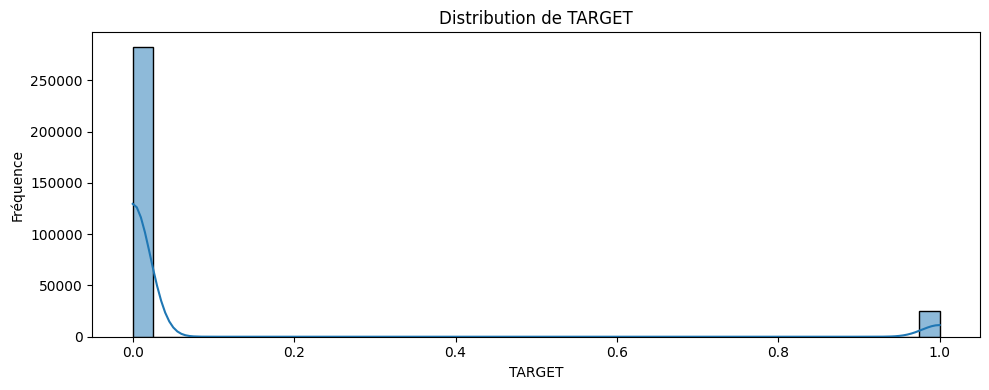

In [9]:
eda.show_column("TARGET")

### Analyse bivariée target
les trois indicateurs les plus positifs et les trois plus négatifs selon la différence normalisée.
Les valeurs positives correspondent aux variables dont l’augmentation est associée à un risque plus élevé, tandis que les valeurs négatives indiquent des variables plutôt protectrices.


In [10]:
top_pos, top_neg = eda.relation_with_target(top=3)
top_pos

,relation_strength
NAME_INCOME_TYPE,0.400000
DAYS_BIRTH,0.287202
REGION_RATING_CLIENT_W_CITY,0.223526


In [11]:
top_neg

,relation_strength
EXT_SOURCE_2,-0.589049
EXT_SOURCE_1,-0.589841
EXT_SOURCE_3,-0.668494


#### NAME_INCOME_TYPE
Les taux de défaut varient fortement selon le type de revenu.
Les catégories Maternity leave (40 %) et Unemployed (36 %) sont les plus risquées.
Les profils Working sont proches de la moyenne, avec un risque modéré.
Les State servant et Pensioner présentent les taux les plus faibles, indiquant une bonne stabilité.
Les catégories Businessman et Student affichent 0 %, mais leurs effectifs sont trop faibles pour conclure.


## Analyse bivariée : **NAME_INCOME_TYPE** vs **TARGET**

### Taux de défaut par catégorie

,taux_defaut
NAME_INCOME_TYPE,
Maternity leave,0.400000
Unemployed,0.363636
Working,0.095885
Commercial associate,0.074843
State servant,0.057550
Pensioner,0.053864
Businessman,0.000000
Student,0.000000


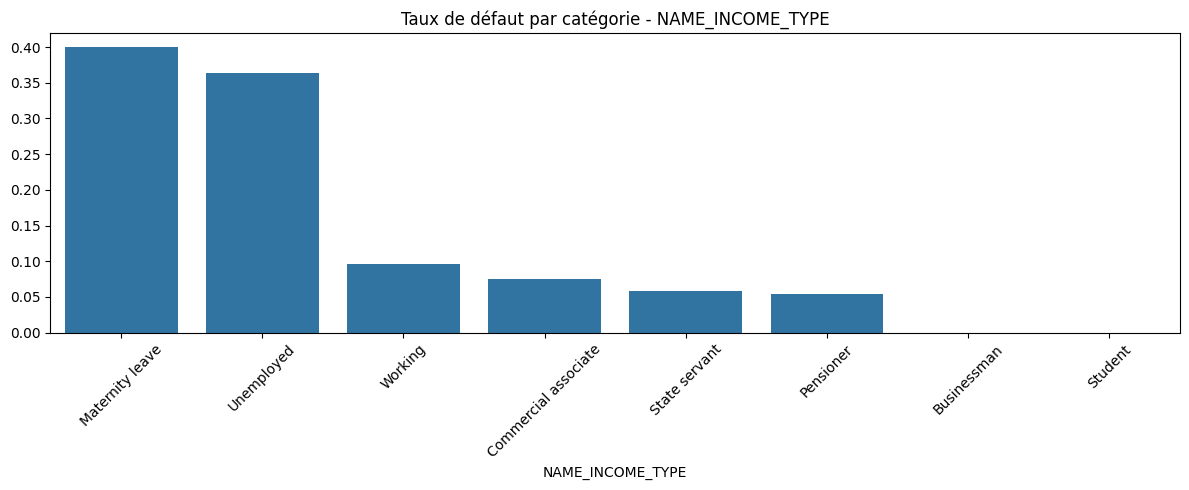

In [12]:
eda.bivariate_with_target("NAME_INCOME_TYPE")

#### DAYS_BIRTH

Les clients en défaut (TARGET = 1) sont nettement plus jeunes que ceux qui remboursent. Leur âge moyen est d’environ 14885 jours (≈ 40,8 ans), contre 16138 jours (≈ 44,2 ans) pour les bons payeurs.

L’écart est visible sur toutes les statistiques : les quartiles, la médiane et les valeurs extrêmes montrent systématiquement des âges plus faibles chez les clients en défaut.

Cet indicateur confirme que la jeunesse est un facteur de risque, tandis que les clients plus âgés présentent un comportement de remboursement plus stable.


## Analyse bivariée : **DAYS_BIRTH** vs **TARGET**

### Résumé statistique par TARGET

TARGET,0,1
count,282686.000000,24825.000000
mean,-16138.176397,-14884.828077
std,4364.200856,4192.844583
min,-25229.000000,-25168.000000
25%,-19793.750000,-18037.000000
50%,-15877.000000,-14282.000000
75%,-12536.000000,-11396.000000
max,-7489.000000,-7678.000000


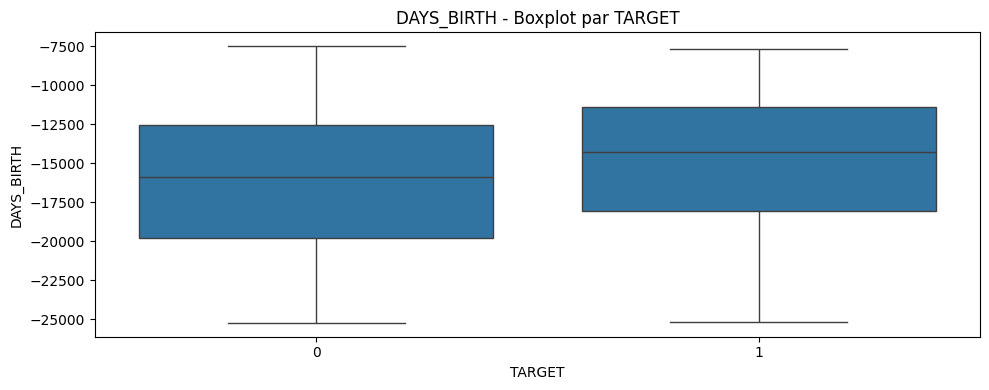

In [13]:
eda.bivariate_with_target("DAYS_BIRTH")

#### REGION_RATING_CLIENT_W_CITY
Les clients en défaut vivent légèrement plus souvent dans des régions moins favorables. Leur score moyen est un peu plus élevé (2.13 contre 2.02), ce qui indique que la qualité de la zone de résidence influence modestement le risque de défaut


## Analyse bivariée : **REGION_RATING_CLIENT_W_CITY** vs **TARGET**

### Résumé statistique par TARGET

TARGET,0,1
count,282686.000000,24825.000000
mean,2.022449,2.134824
std,0.501971,0.499909
min,1.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,3.000000,3.000000


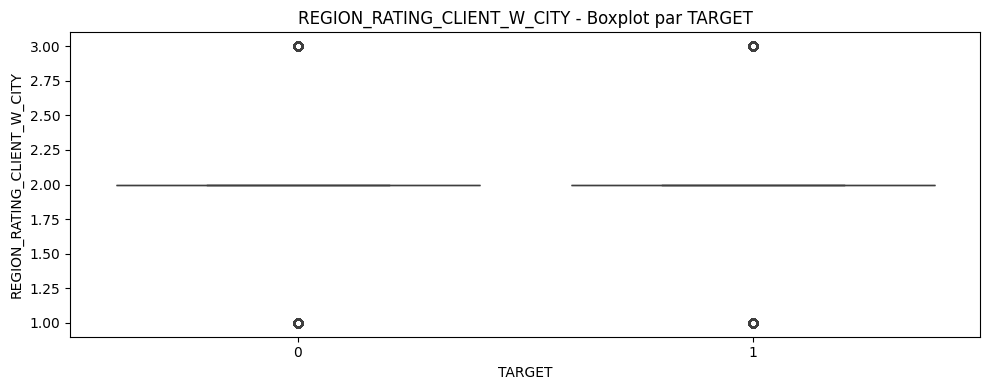

In [14]:
eda.bivariate_with_target("REGION_RATING_CLIENT_W_CITY")

#### EXT_SOURCE_1
EXT_SOURCE_1 est un score externe de solvabilité : plus il est élevé, plus le client est considéré comme fiable.
Les clients qui remboursent ont un score moyen nettement plus haut (0.51) que ceux en défaut (0.39).
Les quartiles confirment cet écart : à chaque niveau (25 %, 50 %, 75 %), les bons payeurs affichent des valeurs supérieures.
Cela montre que EXT_SOURCE_1 est un indicateur très protecteur : un score faible est fortement associé au risque de défaut, tandis qu’un score élevé correspond à un profil beaucoup plus sûr


## Analyse bivariée : **EXT_SOURCE_1** vs **TARGET**

### Résumé statistique par TARGET

TARGET,0,1
count,124079.000000,10054.000000
mean,0.511461,0.386968
std,0.208804,0.204729
min,0.014568,0.014691
25%,0.345430,0.221847
50%,0.517452,0.361675
75%,0.682839,0.537508
max,0.962693,0.929394


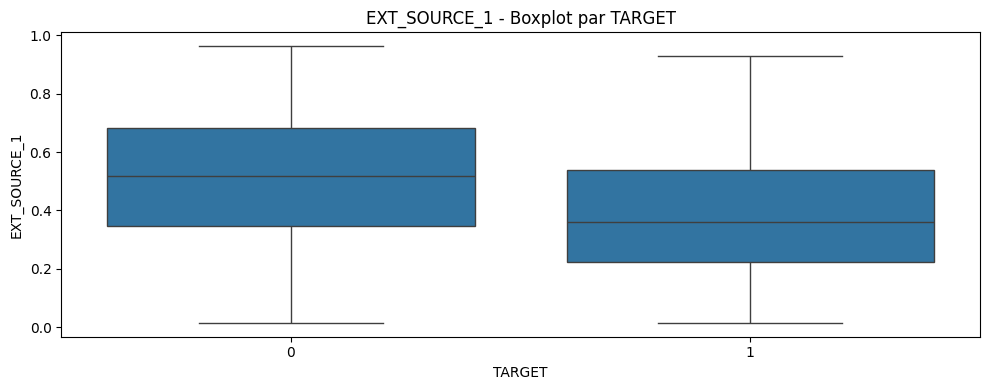

In [15]:
eda.bivariate_with_target("EXT_SOURCE_1")

#### EXT_SOURCE_2
EXT_SOURCE_2 est un score externe de solvabilité, où une valeur élevée correspond à un client plus fiable.
Les bons payeurs ont un score moyen nettement supérieur (0.52) à celui des clients en défaut (0.41).
Les quartiles montrent le même écart : à chaque niveau (25 %, 50 %, 75 %), les clients en défaut ont des scores plus faibles.
Cet indicateur confirme que EXT_SOURCE_2 est fortement protecteur : un score bas est associé à un risque élevé, tandis qu’un score élevé correspond à un profil plus sûr


## Analyse bivariée : **EXT_SOURCE_2** vs **TARGET**

### Résumé statistique par TARGET

TARGET,0,1
count,2.820780e+05,24773.000000
mean,5.234787e-01,0.410935
std,1.862767e-01,0.213107
min,8.173617e-08,0.000005
25%,4.097866e-01,0.238568
50%,5.739047e-01,0.440381
75%,6.677051e-01,0.594190
max,8.549997e-01,0.811870


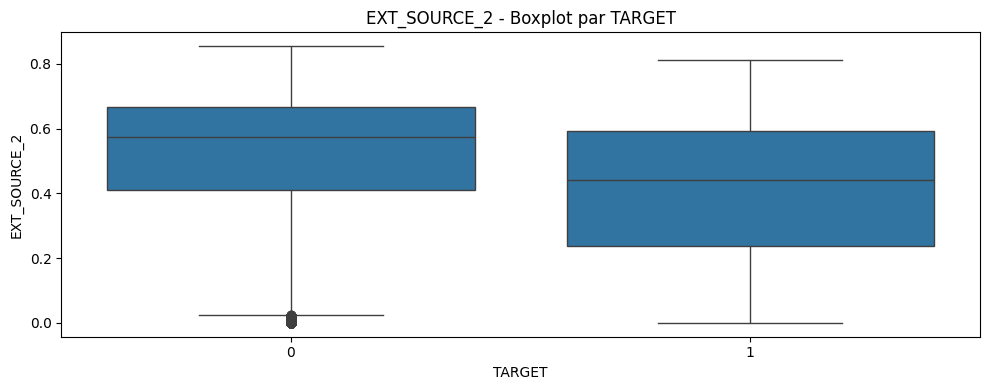

In [16]:
eda.bivariate_with_target("EXT_SOURCE_2")

#### EXT_SOURCE_3
EXT_SOURCE_3 est un score externe de solvabilité, où une valeur élevée indique un client plus fiable.
Les bons payeurs présentent un score moyen nettement supérieur (0.52) à celui des clients en défaut (0.39).
Les quartiles confirment cet écart : à chaque niveau, les clients en défaut ont des scores plus faibles.
Cet indicateur est donc fortement protecteur : un score bas est associé à un risque élevé, tandis qu’un score élevé correspond à un profil beaucoup plus sûr


## Analyse bivariée : **EXT_SOURCE_3** vs **TARGET**

### Résumé statistique par TARGET

TARGET,0,1
count,227398.000000,19148.000000
mean,0.520969,0.390717
std,0.190465,0.205810
min,0.000527,0.000527
25%,0.385915,0.223831
50%,0.546023,0.379100
75%,0.673830,0.553165
max,0.893976,0.896010


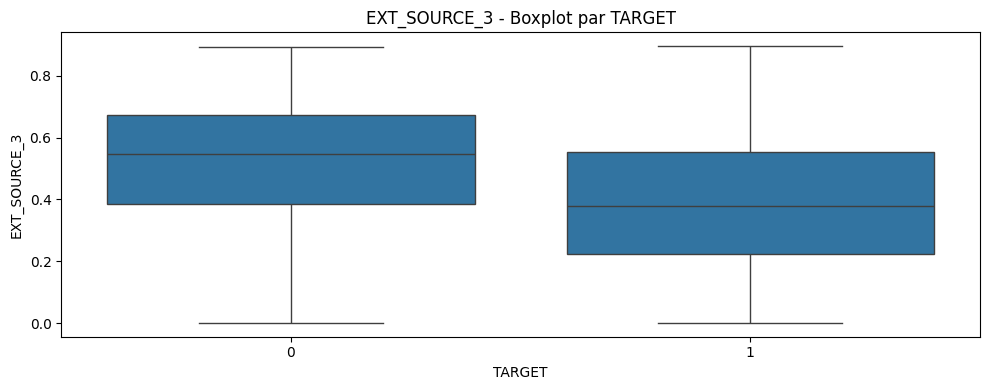

In [17]:
eda.bivariate_with_target("EXT_SOURCE_3")

### Résumé
L’analyse exploratoire met en évidence une structure de données globalement cohérente, mais marquée par plusieurs défis classiques du dataset Home Credit : valeurs manquantes importantes dans certaines familles de variables, forte hétérogénéité des types, et présence d’outliers parfois extrêmes. La target est fortement déséquilibrée, ce qui impose une attention particulière aux métriques et à la validation. Les premières relations avec la target montrent des variables très discriminantes, notamment les scores externes et certains indicateurs socio‑démographiques. Les règles de preprocessing baseline retenues privilégient la simplicité et la robustesse : imputation médiane, flags pour les NA massifs, et conservation de toutes les valeurs brutes. Cette EDA fournit ainsi une base solide pour construire un premier pipeline de modélisation fiable et extensible.

# Analyse de bureau

La table bureau contient l’historique des crédits externes du client, provenant d’autres institutions financières (banques, organismes de crédit, etc.).  

Elle permet d’évaluer :

- la santé financière globale du client  
- son niveau d’endettement externe  
- la qualité de son comportement de remboursement  
- la cohérence entre ses déclarations et les données externes

### Colonnes du dataset

In [18]:
dfs['bureau'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


#### Identifiants
| Colonne | Rôle |
|--------|------|
| SKIDCURR | Identifiant du client (clé pour fusion) |
| SKIDBUREAU | Identifiant unique du crédit externe (clé pour fusion avec bureau_balance) |



#### Colonnes temporelles
| Colonne | Signification |
|--------|---------------|
| DAYS_CREDIT | Nombre de jours depuis l’ouverture du crédit (négatif = passé) |
| DAYSCREDITENDDATE | Nombre de jours jusqu’à la fin prévue du crédit |
| DAYSENDDATEFACT | Nombre de jours jusqu’à la fin réelle du crédit |
| DAYSCREDITUPDATE | Dernière mise à jour du crédit |

Ces colonnes permettent d’évaluer la fraîcheur et la maturité des crédits.



#### Colonnes financières
| Colonne | Signification |
|--------|---------------|
| AMTCREDITSUM | Montant total du crédit |
| AMTCREDITSUM_DEBT | Montant restant dû |
| AMTCREDITSUM_LIMIT | Limite de crédit (cartes, revolving) |
| AMTCREDITSUM_OVERDUE | Montant en retard |
| AMTCREDITMAX_OVERDUE | Maximum historique de retard |
| AMT_ANNUITY | Annuité du crédit |

Ces colonnes permettent d’évaluer :

- l’endettement externe  
- la capacité de remboursement  
- les retards potentiels  



#### Colonnes catégorielles
| Colonne | Signification |
|--------|---------------|
| CREDIT_ACTIVE | Statut du crédit (Active, Closed, Bad debt, Sold…) |
| CREDIT_CURRENCY | Devise du crédit |
| CREDIT_TYPE | Type de crédit (Consumer, Mortgage, Car, Microloan…) |

Elles servent à comprendre la nature du portefeuille de crédits du client.


In [19]:
bureau = QuickEDA(dfs['bureau'], name="bureau",)
num_bureau, cat_bureau, prob_bureau = bureau.run(export=True)

## EDA : **bureau**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\bureau_eda.xlsx


## Relation avec application_train
La table *bureau* est reliée à applicationtrain via la clé SKID_CURR.  
Un client peut apparaître plusieurs fois dans cette table, car il peut avoir eu plusieurs crédits dans d’autres institutions financières.  
Il s’agit donc d’une relation one‑to‑many, essentielle pour comprendre le comportement du client en dehors de Home Credit.


## Vérification des doublons
Avant toute analyse, nous vérifions l’existence de doublons afin d’éviter de biaiser les futures agrégations :

- Doublons exacts : lignes strictement identiques  
- Doublons sur la clé primaire : SKIDBUREAU doit être unique

In [20]:
df_bureau = dfs['bureau']

print("Doublons exacts :",df_bureau.duplicated().sum())
print("Doublons sur SK_ID_BUREAU :", df_bureau['SK_ID_BUREAU'].duplicated().sum())

Doublons exacts : 0
Doublons sur SK_ID_BUREAU : 0


### Analyse des NA
Les NA dans bureau ne sont pas des “manques” mais des informations structurelles.  
Ils reflètent la nature du crédit (revolving, fermé, actif), la disponibilité des données dans le bureau de crédit, et les limites du reporting bancaire.  
> Certains NA sont logiques (non applicable), d’autres sont des erreurs détectables via des flags.


### Actions de nettoyage à appliquer

#### Validation des types
- Conversion explicite des colonnes numériques  
- Conversion des catégorielles en string propre

#### Création de flags d’aberrations
Pour ne pas perdre l’information lors des corrections :

- FLAG_DAYS_CREDIT_POSITIVE → jours positifs (impossible)  
- FLAG_NEGATIVE_AMOUNT → montants négatifs détectés  
- FLAG_DEBTGT_SUM → dette > montant total  

Ces flags sont précieux pour la modélisation.

#### Correction des aberrations
- DAYS_CREDIT > 0 → remplacé par NaN  
- Montants négatifs → remplacés par NaN  
- AMTCREDITSUMDEBT > AMTCREDIT_SUM → dette mise à NaN

#### Gestion des valeurs manquantes
Logique métier :

- AMTCREDITSUM_DEBT → NA = 0  
- AMTCREDITSUM_LIMIT → NA = 0  
- AMTCREDITSUM_OVERDUE → NA = 0  

#### Nettoyage des catégorielles
- Trim  
- Normalisation simple  
- Conservation des NA (traités plus tard en FEATURES)

#### Préparation pour fusion
- SKIDBUREAU → int  
- SKIDCURR → int  


### Etapes après nettoyage
- Fusion avec bureau_balance : enrichir chaque crédit avec son historique
La table bureau_balance contient l’évolution mensuelle de chaque crédit externe (statut mensuel, montants en retard, etc.).  
Elle est liée à bureau via SKIDBUREAU.

- Fusionner avecc bureau_balance permet de :

    - récupérer l’historique complet de chaque crédit  
    - intégrer des informations temporelles (ex : nombre de mois en retard, statut le plus fréquent, etc.)  
    - enrichir chaque ligne de crédit avant l’agrégation  


# Analyse de la table bureau_balance

In [21]:
dfs['bureau_balance'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [22]:
bureau_balance = QuickEDA(dfs['bureau_balance'], name="bureau_balance",)
num_bureau_bal, cat_bureau_bal, prob_bureau_bal = bureau_balance.run(export=True)

## EDA : **bureau_balance**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\bureau_balance_eda.xlsx


## Relation avec bureau
La table bureaubalance est reliée à bureau via la clé SKID_BUREAU.  
Chaque ligne correspond à un mois d’historique pour un crédit externe.  
Il s’agit donc d’une relation one‑to‑many par rapport à bureau, et many‑to-one par rapport à application_train.


## Vérification des doublons
pas de lignes détectés en doublons

## Colonnes importantes à conserver

### MONTHS_BALANCE
- Décalage temporel en mois (0 = mois de la demande, -1 = mois précédent, etc.)
- Permet de mesurer la profondeur historique du crédit.

### STATUS
Statut mensuel du crédit externe.  
Valeurs possibles :
- 0 = payé  
- 1 = retard 1–30 jours  
- 2 = retard 31–60 jours  
- 3 = retard 61–90 jours  
- 4 = retard 91–120 jours  
- 5 = retard 120+ jours  
- C = crédit fermé  
- X = statut inconnu / non applicable

Elles permettent de mesurer :
- la régularité mensuelle du client  
- la fréquence des retards  
- la gravité des retards  
- la durée d’historique disponible  
- la stabilité du crédit externe  



## Préparation détaillée des agrégations

Comme un crédit externe peut avoir plusieurs mois d’historique, nous allons agréger bureaubalance au niveau SKID_BUREAU, puis fusionner avec bureau.

---

### Agrégations numériques sur MONTHS_BALANCE

Nous allons créer :
- BBMONTHSMIN → profondeur historique maximale  
- BBMONTHSMAX → mois le plus récent  
- BBMONTHSCOUNT → nombre total de mois disponibles  

Ces features mesurent la longueur de l’historique.


### Agrégations count sur les statuts

Pour chaque crédit externe, nous allons compter :
- BBCOUNT0 → nombre de mois payés  
- BBCOUNT1 → retards 1–30 jours  
- BBCOUNT2 → retards 31–60 jours  
- BBCOUNT3 → retards 61–90 jours  
- BBCOUNT4 → retards 91–120 jours  
- BBCOUNT5 → retards 120+ jours  
- BBCOUNTC → mois où le crédit est fermé  
- BBCOUNTX → statut inconnu  

Cela permet de capturer la structure complète du comportement mensuel.

---

### Ratios de comportement

Pour normaliser selon la durée du crédit :

- BBRATIOLATE  
  = (mois en retard) / (nombre total de mois)

- BBRATIOSEVERE_LATE  
  = (mois statut 3–5) / total

- BBRATIOCLOSED  
  = mois statut C / total



#### Agrégations catégorielles (fréquences)

Pour chaque modalité de STATUS, on calcule la fréquence :

- BBFREQ0  
- BBFREQ1  
- BBFREQ2  
- BBFREQ3  
- BBFREQ4  
- BBFREQ5  
- BBFREQC  
- BBFREQX

Cela permet de savoir si un crédit est majoritairement sain, majoritairement en retard, etc.


#### Conclusion

La table bureau_balance apporte une vision mensuelle du comportement du client sur ses crédits externes.  
Les agrégations prévues permettront de créer un ensemble de features très informatives :

- profondeur historique  
- fréquence des retards  
- gravité des retards  
- stabilité mensuelle  
- ratios normalisés  


# Analyse de la table previous_application

Cette table contient toutes les demandes de crédit passées du client auprès de Home Credit, qu’elles aient été acceptées, refusées, annulées ou en attente.

Elle décrit :

- le montant demandé  
- le montant accordé  
- le type de crédit  
- le statut final  
- les dates clés  
- les conditions financières  
- le contexte de la demande  

### Colonnes du dataset
### Identifiants

| Colonne | Signification |
|--------|---------------|
| SKIDPREV | Identifiant unique de la demande de crédit passée |
| SKIDCURR | Identifiant du client (clé pour fusion avec application) |



### Type de contrat

| Colonne | Signification |
|--------|---------------|
| NAMECONTRACTTYPE | Type de crédit demandé (Cash loans, Revolving loans…) |
| NAMECONTRACTSTATUS | Statut final de la demande (Approved, Refused, Canceled…) |
| NAMEPRODUCTTYPE | Produit financier (x-sell, walk-in, POS, etc.) |
| NAME_PORTFOLIO | Portefeuille interne (POS, Cash, Cards…) |
| PRODUCT_COMBINATION | Combinaison produit (ex : Cash + POS) |



### Montants financiers

| Colonne | Signification |
|--------|---------------|
| AMT_APPLICATION | Montant demandé par le client |
| AMT_CREDIT | Montant réellement accordé par Home Credit |
| AMTGOODSPRICE | Prix du bien financé (si achat) |
| AMT_ANNUITY | Annuité du crédit (si applicable) |
| AMTDOWNPAYMENT | Apport personnel du client |
| RATEDOWNPAYMENT | Taux d’apport personnel |
| RATEINTERESTPRIMARY | Taux d’intérêt standard |
| RATEINTERESTPRIVILEGED | Taux d’intérêt préférentiel |

Ces colonnes permettent d’évaluer :  
- la cohérence entre montant demandé / accordé  
- la capacité financière  
- le niveau de risque perçu par Home Credit



### Dates et délais

| Colonne | Signification |
|--------|---------------|
| DAYS_DECISION | Nombre de jours entre la demande et la décision |
| DAYSFIRSTDRAWING | Jours avant le premier décaissement |
| DAYSFIRSTDUE | Jours avant la première échéance |
| DAYSLASTDUE1STVERSION | Dernière échéance prévue initialement |
| DAYSLASTDUE | Dernière échéance réelle |
| DAYS_TERMINATION | Date de clôture du crédit |

Ces colonnes sont essentielles pour comprendre :  
- la durée du crédit  
- les modifications de calendrier  
- les crédits annulés ou jamais utilisés



### Informations sur le processus de demande

| Colonne | Signification |
|--------|---------------|
| WEEKDAYAPPRPROCESS_START | Jour de la semaine de la demande |
| HOURAPPRPROCESS_START | Heure de la demande |
| FLAGLASTAPPLPERCONTRACT | Indique si c’est la dernière demande pour ce contrat |
| NFLAGLASTAPPLINDAY | Indique si c’est la dernière demande du jour |
| NAMEPAYMENTTYPE | Mode de paiement (cash, POS, etc.) |
| CHANNEL_TYPE | Canal de demande (bureau, en ligne, partenaire…) |
| SELLERPLACE_AREA | Zone géographique du vendeur |
| NAMESELLERINDUSTRY | Secteur du vendeur |

 Ces colonnes capturent le contexte opérationnel de la demande.



### Profil client lors de la demande

| Colonne | Signification |
|--------|---------------|
| NAMECASHLOAN_PURPOSE | Motif du crédit (réparation, achat, urgence…) |
| NAMETYPESUITE | Qui accompagnait le client (alone, family, spouse…) |
| NAMECLIENTTYPE | Type de client (new, returning, VIP…) |
| NAMEGOODSCATEGORY | Catégorie du bien financé |
| NAMEYIELDGROUP | Segment de rentabilité du client |

 Très utile pour comprendre le comportement historique du client.



### Structure du crédit

| Colonne | Signification |
|--------|---------------|
| CNT_PAYMENT | Nombre d’échéances prévues |

 Permet de dériver la durée du crédit.



### Assurance

| Colonne | Signification |
|--------|---------------|
| NFLAGINSUREDON_APPROVAL | Indique si le crédit était assuré |


In [23]:
dfs['previous_application'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [24]:
previous_application= QuickEDA(dfs['previous_application'], name="previous_application",)
num_prev, cat_prev, prob_prev = previous_application.run(export=True)

## EDA : **previous_application**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\previous_application_eda.xlsx


## Relation avec application_train
La table previousapplication est reliée à application_train via la clé SKIDCURR.  
Chaque ligne correspond à une ancienne demande de crédit faite par le client chez Home Credit.  
Il s’agit donc d’une relation one‑to‑many : un client peut avoir plusieurs demandes passées.

Cette table permet d’évaluer :
- l’historique interne du client  
- la cohérence de ses demandes  
- ses comportements passés (acceptations, refus, montants, durées)




 ## Vérification des doublons
 pas de doublons

In [25]:
print("Doublons sur SKIDPREV :", dfs['previous_application']['SK_ID_PREV'].duplicated().sum())

Doublons sur SKIDPREV : 0




### Validation des types
Certaines colonnes doivent être explicitement converties :

- numériques : montants, taux, jours, durées  
- catégorielles : types de contrats, statuts, motifs, canaux  
- identifiants : SKIDPREV, SKIDCURR

On convertit en float, int ou string selon le cas.
### Création de flags d’aberrations
Les statistiques montrent plusieurs anomalies :

Montants négatifs
- AMTDOWNPAYMENT  
- RATEDOWNPAYMENT  
→ aberrant → flag + correction

Taux d’intérêt NA massifs
- RATEINTERESTPRIMARY  
- RATEINTERESTPRIVILEGED  
→ NA logique → flag NA_massif

Montants incohérents
- AMTCREDIT > AMTAPPLICATION  
- AMTANNUITY > AMTCREDIT  
→ flag + correction

Jours impossibles
- valeurs > 365243  
- valeurs positives pour des jours censés être négatifs  
→ flag + correction

Les flags permettent de ne pas perdre l’information de l’anomalie, très utile pour le modèle.


### Correction des aberrations
Sur la base des statistiques :

###  Montants négatifs → NaN
Ex : AMTDOWNPAYMENT = -0.9

### Taux négatifs → NaN
Ex : RATEDOWNPAYMENT = -1.49e-05

###  Montants incohérents
- si AMTCREDIT > AMTAPPLICATION → AMT_CREDIT = NaN  
- si AMTANNUITY > AMTCREDIT → AMT_ANNUITY = NaN

###  Jours impossibles
Les colonnes DAYS_* contiennent des valeurs absurdes (ex : 365243).  
→ on remplace par NaN (valeur manquante logique)

---

### Gestion des NA
Les statistiques montrent des NA massifs dans :

- RATEINTERESTPRIMARY (99.64 % NA)  
- RATEINTERESTPRIVILEGED (99.64 % NA)  
- AMTDOWNPAYMENT (46 % NA)  
- RATEDOWNPAYMENT (46 % NA)  
- DAYSFIRSTDRAWING (40 % NA)  
- DAYSFIRSTDUE (40 % NA)  
- DAYSLASTDUE (40 % NA)  
- DAYS_TERMINATION (40 % NA)  
- NAMETYPESUITE (50 % NA)

On applique une logique métier :

NA = 0
Seulement quand c’est logiquement justifié :  
- AMTDOWNPAYMENT  
- RATEDOWNPAYMENT  
- CNT_PAYMENT

NA conservés
Quand la valeur est structurellement manquante :  
- taux d’intérêt  
- dates de due / termination  
- type suite  
- product combination (rare NA)

---

###  Nettoyage des catégorielles
Les colonnes catégorielles sont propres mais :

- certaines ont une dominance forte (ex : FLAGLASTAPPLPERCONTRACT = Y à 99.49 %)  
- certaines ont des valeurs XNA / XAP → valeurs manquantes codées  
- certaines ont une cardinalité élevée (ex : NAMEGOODSCATEGORY)

Actions :

- trim + normalisation  
- remplacement de XNA / XAP par NaN  
- conservation des NA pour traitement en FEATURES

###  Préparation pour agrégation
Avant d’agréger par SKIDCURR, on s’assure que :

- SKIDPREV est unique par ligne  
- SKIDCURR est bien typé  
- toutes les colonnes sont propres et cohérentes

L’agrégation permettra ensuite de résumer :

- montants demandés / accordés  
- taux  
- durées  
- statuts  
- flags d’anomalies  
- comportements historiques



### Synthèse 

> Le CLEAN de previous_application consiste à valider les types, identifier les valeurs impossibles, créer des flags d’aberrations et remplacer uniquement les valeurs sentinelles ou incohérentes par NaN.  
> Aucun champ n’est supprimé et toutes les informations sont conservées pour la modélisation.

# Analyse de la table POSCASHbalance

POSCASHbalance contient l’historique mensuel des crédits POS (Point‑of‑Sale) et Cash accordés par Home Credit.
Chaque ligne = un mois d’historique pour un crédit POS/Cash.

Elle permet d’analyser :

- le comportement de remboursement mensuel  
- les retards  
- la progression du nombre d’échéances restantes  
- le statut mensuel du contrat  



### Colonnes du dataset
#### SKIDPREV
- Identifiant unique du crédit POS/Cash.
- Plusieurs lignes par crédit (une par mois).
- Sert à fusionner avec previous_application.
SKIDCURR
- Identifiant du client.
- Permet d’agréger au niveau client après fusion.



#### MONTHS_BALANCE
- Valeurs : 0, -1, -2, … jusqu’à environ -96.
- 0 = mois courant  
- -1 = mois précédent  
- -2 = deux mois avant  
- etc.

C’est un compteur temporel négatif qui indique à quel mois correspond la ligne.



#### CNT_INSTALMENT
- Nombre total d’échéances prévues pour ce crédit au moment du mois donné.
- Peut changer dans le temps (renégociation, restructuration).

Permet de comprendre la durée initiale du crédit.



#### CNTINSTALMENTFUTURE
- Nombre d’échéances restantes à payer au moment du mois donné.
- Diminue au fil du temps.

#### Permet de mesurer :
- l’avancement du crédit  
- les retards (si ça ne diminue pas)  
- les restructurations (si ça augmente)



#### NAMECONTRACTSTATUS
Statut du contrat pour ce mois précis.

Valeurs possibles (9 catégories) :

- Active → crédit en cours  
- Completed → crédit terminé  
- Signed → contrat signé mais pas encore actif  
- Approved  
- Canceled  
- Refused  
- Amortized debt  
- XNA → inconnu  
- etc.

Très utile pour détecter :
- les crédits terminés  
- les crédits annulés  
- les comportements atypiques

---

#### SK_DPD
- Nombre de jours de retard (Days Past Due) pour ce mois.
- 0 = aucun retard  
- >0 = retard réel

C’est un indicateur clé du comportement de remboursement.



#### SKDPDDEF
- Nombre de jours de retard défaut (seuil plus strict).
- Souvent utilisé pour détecter les retards sérieux.

Très utile pour créer :
- un flag “retard sérieux”  
- un nombre de mois en défaut  
- un maximum de retard


In [26]:
dfs['POS_CASH_balance'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [27]:
POS_CASH_balance = QuickEDA(dfs['POS_CASH_balance'], name="POS_CASH_balance",)
num_pos, cat_pos, prob_pos = POS_CASH_balance.run(export=True)

## EDA : **POS_CASH_balance**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\POS_CASH_balance_eda.xlsx



## Relation avec previous_application
La table POSCASHbalance est reliée à previousapplication via la clé SKID_PREV.  
Chaque ligne correspond à un mois d’historique d’un crédit POS ou Cash Loan.

Structure relationnelle :
`
applicationtrain → previousapplication → POSCASHbalance
       1 → N → M

C’est une table mensuelle, comme bureau_balance, mais pour les crédits internes Home Credit.

## Vérification des doublons
pas de doublons

In [28]:
dfs['POS_CASH_balance'][['SK_ID_PREV', 'MONTHS_BALANCE']].duplicated().sum()

0

## Colonnes importantes à conserver

1. MONTHS_BALANCE
- Décalage temporel en mois (0 = mois de la demande, -1 = mois précédent…)
- Permet de mesurer la profondeur historique du crédit POS/Cash.

2. SK_DPD
- Nombre de jours de retard (Days Past Due) pour ce mois.
- Indicateur direct de retard mensuel.

3. SKDPDDEF
- Retard “définitif” (défaut).
- Très prédictif du risque.

4. NAMECONTRACTSTATUS
Statut mensuel du crédit :
- Active  
- Completed  
- Signed  
- Returned to the store  
- Approved  
- Canceled  
- Refused  


Elles permettent de mesurer :
- la régularité mensuelle du client  
- la fréquence des retards  
- la gravité des retards  
- la durée d’historique disponible  
- la stabilité des crédits POS/Cash  

## Préparation détaillée des agrégations (future feature engineering)

Comme un crédit interne peut avoir plusieurs mois d’historique, nous allons agréger POSCASHbalance au niveau SKIDPREV, puis fusionner avec previous_application.

---

### Agrégations numériques

Colonnes concernées
- MONTHS_BALANCE  
- SK_DPD  
- SKDP_DDEF

Pour chacune :
- mean  
- min  
- max  
- sum  
- std  


### Agrégations count

Features créées
- POS_COUNT_MONTHS → nombre total de mois disponibles  
- POS_COUNT_LATE → mois avec retard (SK_DPD > 0)  
- POS_COUNT_SEVERELATE → mois avec défaut (SKDPD_DEF > 0)  
- POS_COUNT_RECENT → mois récents (MONTHS_BALANCE > -12)

Ces counts capturent la fréquence des retards.



### Ratios de comportement

Features créées
- POS_RATIO_LATE  
  = mois en retard / total des mois

- POS_RATIO_SEVERE_LATE  
  = mois en défaut / total

- POS_RATIO_COMPLETED  
  = mois statut Completed / total

Ces ratios normalisent selon la durée du crédit.



### Agrégations catégorielles (fréquences)

Colonnes concernées
- NAME_CONTRACT_STATUS

Features créées
- POS_STATUS_ACTIVE_FREQ  
- POS_STATUS_COMPLETED_FREQ  
- POS_STATUS_RETURNED_FREQ  
- POS_STATUS_CANCELED_FREQ  
- POS_STATUS_REFUSED_FREQ  

Cela permet de comprendre la stabilité mensuelle du crédit.




## Conclusion

La table POSCASHbalance fournit une vision mensuelle du comportement du client sur ses crédits POS/Cash internes.  
Les agrégations prévues permettront de créer un ensemble de features très informatives :

- profondeur historique  
- fréquence des retards  
- gravité des retards  
- stabilité mensuelle  
- ratios normalisés  

Ces signaux complètent parfaitement previous_application et enrichissent fortement le modèle.

# Analyse de la table installments_payments
Cette table contient tous les paiements mensuels effectués par le client pour tous ses crédits passés (SKIDPREV).


## Colonne du dataset
### SKIDPREV
- Identifiant du crédit (prêt, POS, cash, etc.)
- Plusieurs lignes par crédit (une par échéance ou paiement)

Sert à fusionner avec previous_application.



### SKIDCURR
- Identifiant du client
- Permet d’agréger au niveau client après agrégation par crédit

Sert à fusionner avec application_train.



### NUMINSTALMENTVERSION
- Version du plan d’échéances
- Peut changer si le crédit est renégocié, restructuré ou modifié

Indique si le client a eu des réaménagements de dette.



### NUMINSTALMENTNUMBER
- Numéro de l’échéance (1, 2, 3, …)
- Correspond à la position de l’échéance dans le plan de remboursement

Permet de mesurer :
- la durée du crédit  
- la progression du remboursement  
- les retards chroniques  



### DAYS_INSTALMENT
- Jour prévu pour le paiement de l’échéance  
- Valeur négative = nombre de jours avant la date de référence (demande)

C’est la date théorique du paiement.



### DAYSENTRYPAYMENT
- Jour où le paiement a réellement été effectué  
- Valeur négative = paiement dans le passé  
- Peut être > DAYS_INSTALMENT → retard  
- Peut être < DAYS_INSTALMENT → paiement anticipé

C’est la date réelle du paiement.



### AMT_INSTALMENT
- Montant prévu pour l’échéance  
- Ce que le client devait payer

 Sert à mesurer :
- les paiements partiels  
- les paiements manquants  
- les paiements en excès  



### AMT_PAYMENT
- Montant réellement payé par le client  
- Peut être :
  - égal au montant prévu  
  - inférieur (paiement partiel)  
  - supérieur (paiement anticipé ou frais)  
  - 0 (non‑paiement)

In [29]:
dfs['installments_payments'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [30]:
installments_payments = QuickEDA(dfs['installments_payments'], name="installments_payments",)
num_ins, cat_ins, prob_ins = installments_payments.run(export=True)

## EDA : **installments_payments**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\installments_payments_eda.xlsx


## Relation avec previous_application
La table installmentspayments est reliée à previousapplication via la clé SKIDPREV.  
Chaque ligne correspond à un paiement d’échéance effectué par le client.

Structure relationnelle :

`
applicationtrain → previousapplication → installments_payments
       1 → N → M
`

- 1 client peut avoir N anciens crédits  
- 1 ancien crédit peut avoir M paiements d’échéances

## Vérification des doublons
pas de ligne en double

## Colonnes importantes à conserver

Montants
- AMT_INSTALMENT : montant prévu de l’échéance.  
- AMT_PAYMENT : montant réellement payé.  

Ce sont les deux colonnes essentielles pour analyser la discipline de paiement.



 Temporalité
- DAYS_INSTALMENT : date prévue du paiement.  
- DAYSENTRYPAYMENT : date réelle du paiement.

Elles permettent de mesurer retards, avances et durée réelle du crédit.



Comportement (colonnes calculées)

- DAYSLATE = DAYSENTRYPAYMENT − DAYSINSTALMENT  
  → retard réel  
  → positif = retard  
  → négatif = paiement en avance  

- PAYMENTDIFF = AMTPAYMENT − AMT_INSTALMENT  
  → surpaiement ou sous‑paiement  
  → négatif = paiement insuffisant  
  → positif = paiement supérieur au dû  

- PAYMENTRATIO = AMTPAYMENT / AMT_INSTALMENT  
  → indicateur de discipline  
  → < 1 = sous‑paiement  
  → = 1 = paiement exact  
  → > 1 = surpaiement  

Ces colonnes sont extrêmement prédictives.

---

Elles permettent de mesurer :

- si le client paye en retard  
- s’il paye moins que prévu  
- s’il paye en avance  
- la régularité de ses paiements  
- la gravité des retards  
- la fréquence des retards  
- la tendance à sous‑payer  

## Préparation détaillée des agrégations (future feature engineering)

Nous allons agréger au niveau SKIDPREV, puis fusionner le résultat avec previous_application.



### Agrégations numériques

Colonnes concernées :

- AMT_INSTALMENT  
- AMT_PAYMENT  
- INSTPAYMENTDIFF  
- INSTPAYMENTRATIO  
- DAYS_INSTALMENT  
- DAYSENTRYPAYMENT  
- INSTDAYSLATE

Pour chacune, nous calculerons :

- mean  
- min  
- max  
- sum  
- std

Exemples de features créées :

- INSTPAYMENTRATIO_MEAN  
- INSTDAYSLATE_MAX  
- INSTAMTPAYMENT_SUM  
- INSTPAYMENTDIFF_MEAN



### Agrégations count

Features créées :

- INSTCOUNTPAYMENTS → nombre total de paiements  
- INSTCOUNTLATE → paiements en retard (INSTPAIDLATE)  
- INSTCOUNTEARLY → paiements en avance (INSTPAIDEARLY)  
- INSTCOUNTUNDERPAID → paiements insuffisants (INST_UNDERPAID)  
- INSTCOUNTOVERPAID → paiements supérieurs (INST_OVERPAID)  
- INSTCOUNTZERO → paiements nuls (INSTZEROPAYMENT)

Ces indicateurs capturent la discipline de paiement du client.



### Ratios comportementaux

Features créées :

- INSTRATIOLATE  
  = paiements en retard / total

- INSTRATIOEARLY  
  = paiements en avance / total

- INSTRATIOUNDERPAID  
  = paiements insuffisants / total

- INSTRATIOOVERPAID  
  = paiements supérieurs / total

Ces ratios permettent de normaliser le comportement selon le nombre total de paiements.



### Agrégations temporelles

Features créées :

- INSTLASTPAYMENT_DAYS  
  = max(DAYSENTRYPAYMENT)

- INSTFIRSTPAYMENT_DAYS  
  = min(DAYSENTRYPAYMENT)

- INSTPAYMENTSPAN  
  = durée totale entre premier et dernier paiement  
  = max(DAYSENTRYPAYMENT) - min(DAYSENTRYPAYMENT)

Ces indicateurs mesurent la durée réelle du crédit et la régularité des paiements.

## Conclusion

La table installments_payments est l’une des plus riches du dataset.  
Elle permet de capturer :

- la discipline de paiement  
- la gravité des retards  
- la cohérence entre prévu et payé  
- la stabilité temporelle  
- la qualité du comportement financier interne  

Les agrégations prévues permettront de créer un ensemble de features très discriminantes, essentielles pour améliorer le modèle.

## Conclusion

La table installments_payments est l’une des plus riches du dataset.  
Elle permet de capturer :

- la discipline de paiement  
- la gravité des retards  
- la cohérence entre prévu et payé  
- la stabilité temporelle  
- la qualité du comportement financier interne  


# Analyse de credit_card_balance
La table creditcardbalance décrit mois par mois l’utilisation et le remboursement d’un crédit revolving.  
Elle permet de mesurer :  
- l’utilisation du crédit (solde, limite, dépenses)  
 - la discipline de paiement (paiement minimum, paiement réel)  
 - les comportements risqués (ATM, dépassements, retards)  
  
Elle doit être agrégée au niveau SKIDPREV, puis fusionnée avec previous_application.


In [31]:
credit_card_balance = QuickEDA(dfs['credit_card_balance'], name="credit_card_balance",)
num_cre, cat_cre, prob_cre = credit_card_balance.run(export=True)

## EDA : **credit_card_balance**

###  Doublons détectés : **0**

Export Excel terminé : ../../reports/eda\credit_card_balance_eda.xlsx


In [32]:
dfs['credit_card_balance'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

## Relation avec previous_application
La table creditcardbalance est reliée à previousapplication via la clé SKID_PREV.  
Chaque ligne correspond à un mois d’historique d’une carte de crédit interne.

Structure relationnelle :

`
applicationtrain → previousapplication → creditcardbalance
        1 → N → M
`

- 1 client peut avoir N anciens crédits  
- 1 ancien crédit peut avoir M mois d’historique de carte de crédit  

## Vérification des doublons

## Colonnes importantes à conserver

Montants
- AMT_BALANCE : solde actuel de la carte.  
- AMTCREDITLIMIT_ACTUAL : limite de crédit autorisée.  
- AMTPAYMENTCURRENT : montant payé ce mois‑ci.  
- AMTPAYMENTTOTAL_CURRENT : total payé (inclut intérêts).  
- AMTRECEIVABLEPRINCIPAL / AMTTOTALRECEIVABLE : dette restante.

Ces colonnes décrivent l’utilisation du crédit et la capacité de remboursement.



Activité
- AMTDRAWINGSCURRENT / POS / ATM / OTHER : montants retirés.  
- CNTDRAWINGSCURRENT / POS / ATM / OTHER : fréquence des retraits.  
- CNTINSTALMENTMATURE_CUM : nombre d’échéances arrivées à maturité.

Elles mesurent l’intensité d’utilisation de la carte.



Temporalité
- MONTHS_BALANCE : mois relatif (0 = mois courant, -1 = mois précédent, etc.)

Permet d’évaluer la récence et la profondeur historique.



Risque / Retards
- SK_DPD : jours de retard.  
- SKDPDDEF : jours de retard en défaut (plus grave).  
- NAMECONTRACTSTATUS : statut mensuel de la carte.

Colonnes essentielles pour détecter retards, défauts et comportements risqués.



Colonnes comportementales calculées (features)

À partir des colonnes brutes, on calcule :

- CCUTILIZATION = AMTBALANCE / AMTCREDITLIMIT_ACTUAL  
  → taux d’utilisation du crédit

- CCLATE = SKDPD > 0  
  → indicateur de retard

- CCSEVERELATE = SKDPDDEF > 0  
  → indicateur de défaut grave

- CCDRAWINGSTOTAL = somme des retraits (ATM + POS + OTHER)  
  → activité totale

Ces features capturent la pression financière, la discipline, et le risque.



Ce que ces colonnes permettent de mesurer

- le niveau d’endettement réel  
- la pression sur la limite de crédit  
- la fréquence et le type de retraits  
- la capacité de remboursement mensuelle  
- les retards et défauts  
- la récence des comportements risqués  
- la stabilité ou instabilité du compte  

Préparation détaillée des agrégations (future feature engineering)

Nous allons agréger au niveau SKIDPREV, puis fusionner le résultat avec previous_application.



### Agrégations numériques

Colonnes concernées :

- AMT_BALANCE  
- AMTCREDITLIMIT_ACTUAL  
- AMTDRAWINGSATM_CURRENT  
- AMTDRAWINGSCURRENT  
- AMTDRAWINGSOTHER_CURRENT  
- AMTDRAWINGSPOS_CURRENT  
- AMTINSTMIN_REGULARITY  
- AMTPAYMENTCURRENT  
- AMTPAYMENTTOTAL_CURRENT  
- AMTRECEIVABLEPRINCIPAL  
- AMT_RECIVABLE  
- AMTTOTALRECEIVABLE  
- CNTDRAWINGSATM_CURRENT  
- CNTDRAWINGSCURRENT  
- CNTDRAWINGSOTHER_CURRENT  
- CNTDRAWINGSPOS_CURRENT  
- CNTINSTALMENTMATURE_CUM  
- SK_DPD  
- SKDPDDEF  
- CC_UTILIZATION (feature calculée)  
- CCDRAWINGSTOTAL (feature calculée)

Pour chacune, nous calculerons :

- mean  
- min  
- max  
- sum  
- std

Exemples de features créées :

- CCUTILIZATIONMEAN  
- AMTBALANCEMAX  
- AMTPAYMENTTOTALCURRENTSUM  
- SKDPDMEAN  



### Agrégations count

Features créées :

- CCCOUNTMONTHS → nombre total de mois d’historique  
- CCCOUNTLATE → mois avec retard (SK_DPD > 0)  
- CCCOUNTSEVERELATE → mois en défaut (SKDPD_DEF > 0)  
- CCCOUNTACTIVE → mois où la carte est active  
- CCCOUNTDRAWINGS → mois avec retraits (tous types confondus)

Ces indicateurs capturent :

- la fréquence des retards  
- la gravité des retards  
- l’activité réelle de la carte  
- la stabilité du compte  



Ratios comportementaux

Features créées :

- CCRATIOLATE  
  = mois en retard / total

- CCRATIOSEVERE_LATE  
  = mois en défaut / total

- CCRATIOACTIVE  
  = mois actifs / total

- CCRATIODRAWINGS  
  = mois avec retraits / total

Ces ratios permettent de normaliser le comportement selon la profondeur historique.


### Agrégations temporelles

Features créées :

- CCLASTMONTH  
  = max(MONTHS_BALANCE)  
  → récence maximale (souvent 0)

- CCFIRSTMONTH  
  = min(MONTHS_BALANCE)  
  → profondeur historique

- CCHISTORYSPAN  
  = durée totale d’historique  
  = max(MONTHSBALANCE) − min(MONTHSBALANCE)

Ces indicateurs mesurent :

- la récence des comportements risqués  
- la longueur d’historique disponible  
- la stabilité du compte dans le temps




# Preprocessing (baseline)

L’objectif de cette baseline est de construire un pipeline :

- simple  
- reproductible  
- robuste  
- sans fuite de données  

Nous privilégions :
- un nettoyage minimal,
- des règles métier explicites,
- des flags informatifs,
- et des transformations apprises uniquement sur TRAIN.

Les optimisations avancées (feature engineering complexe, suppression de variables, transformations non linéaires) seront réalisées dans une seconde phase après évaluation du modèle de référence.